## Analysis for APEX (Atacama Pathfinder Experiment)

* location: https://maps.app.goo.gl/vN2AU8vE6jiQkYnN6
* website: http://www.apex-telescope.org/ns/es/pagina-web-apex/

In [1]:
# packages 
import pandas as pd
import numpy as np
from pymongo import MongoClient
import missingno as msno 

import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns


In [2]:
## connecting
db_name = "meteo_apex"
client = MongoClient("mongodb://localhost:27017/")
db = client[db_name] # meteo_paranal_test
collection = db[db_name]

In [3]:
collection.find_one({})

{'_id': ObjectId('65c3f76bb45d56ad5d89448b'),
 'Date time': '2006-01-01T15:03:00',
 'Dew Point [C]': -7.51,
 'Humidity [%]': 40.16,
 'Pressure [hPa]': 553.38,
 'Temperature [C]': 3.78,
 'Wind Direction [deg]': 261.0,
 'Wind Speed [m/s]': 2.2}

In [7]:
print('Total samples in db: ',collection.count_documents({}))

Total samples in db:  8943929


We can see all the fields related with one sample in our pymongo instance

In the next code we can see total samples per year

In [5]:
## samples per year
pipeline = [
    {   # it extracts the year from Date time
        "$project": { "year": {"$year": {"$dateFromString": {"dateString": "$Date time"}}},}
    },
    { "$group": {# grouping by year and sum per sample 
            "_id": "$year",
            "count": {"$sum": 1}}
    },
    {"$sort": {"_id": 1}  # sort by year in ascending order
    }
]
result = list(collection.aggregate(pipeline))
for result_it in result:
    print(f"Year: {result_it['_id']}, Count: {result_it['count']}")

Year: 2006, Count: 486143
Year: 2007, Count: 481734
Year: 2008, Count: 489020
Year: 2009, Count: 464069
Year: 2010, Count: 485864
Year: 2011, Count: 422112
Year: 2012, Count: 502502
Year: 2013, Count: 499300
Year: 2014, Count: 498506
Year: 2015, Count: 514753
Year: 2016, Count: 515337
Year: 2017, Count: 501133
Year: 2018, Count: 523526
Year: 2019, Count: 514594
Year: 2020, Count: 502994
Year: 2021, Count: 500144
Year: 2022, Count: 516848
Year: 2023, Count: 480782
Year: 2024, Count: 44568


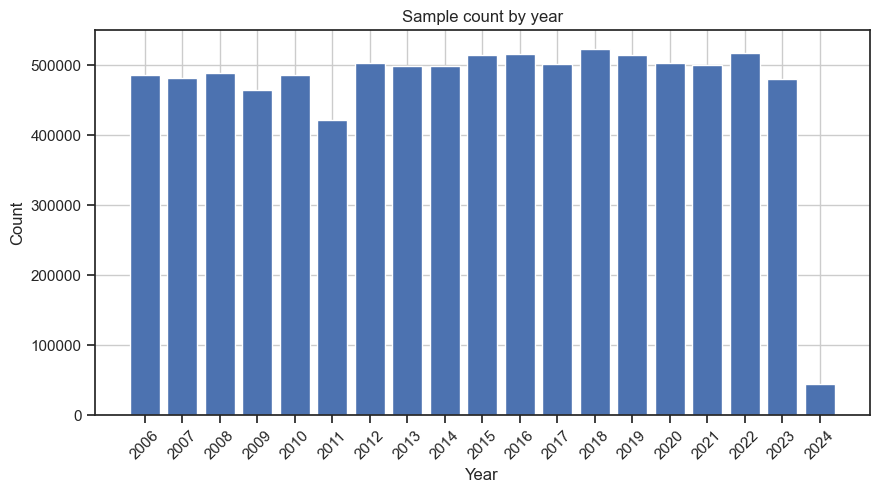

In [6]:
years = [result_it['_id'] for result_it in result]
counts = [result_it['count'] for result_it in result]

fig, ax = plt.subplots(figsize=(10,5))
plt.bar(years, counts)
plt.xticks(years,rotation=45)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Sample count by year')
plt.grid(True)
plt.show()

There are a few of them which does not have enough samples, we should have 525600 sample if our data comes per minute

Now we do an analysis aggregated per hour in order to upload all dataset and not jus a part
 

In [7]:
## utils functions (skip this cell)

def dict_to_datetime(x):
   return f"{x['year']}-{x['month']}-{x['day']} {x['hour']}:00:00"


def get_datetime_index(df):
    df['_id'] = pd.to_datetime(df['_id'].apply(dict_to_datetime))
    df = df.set_index(['_id'])
    df = df.sort_index(ascending=True)
    return df

def get_df(aggregated_expression):

    pipeline = [
        {"$group": {
                "_id": {
                    "year": {"$year": {"$dateFromString": {"dateString": "$Date time"}}},
                    "month": {"$month": {"$dateFromString": {"dateString": "$Date time"}}},
                    "day": {"$dayOfMonth": {"$dateFromString": {"dateString": "$Date time"}}},
                    "hour": {"$hour": {"$dateFromString": {"dateString": "$Date time"}}},
                }, 
                **aggregated_expression}},
        {"$sort": {"_id.year": 1, "_id.month": 1, "_id.day": 1, "_id.hour": 1} }
    ]

    result = list(collection.aggregate(pipeline))

    return pd.DataFrame(result)



These are the official columns we use

In [8]:
numeric_col = [
    'Dew Point [C]',
    'Humidity [%]',
    'Temperature [C]',
    'Wind Direction [deg]',
    'Wind Speed [m/s]'
 ]

In [9]:
## uploading data

# defining what we want
mean_agg = {f: {"$avg": f"${f}"} for f in numeric_col}

# getting df
df_mean = get_df(mean_agg)

# getting datetime index
df_mean = get_datetime_index(df_mean)

In [16]:
df=df_mean.copy() # just for safe
print('DF shape: ',df.shape)
display(df.head(3))

DF shape:  (150680, 5)


,Dew Point [C],Humidity [%],Temperature [C],Wind Direction [deg],Wind Speed [m/s]
_id,,,,,
2006-01-01 15:00:00,-6.344000,44.518000,3.246000,252.200000,4.380000
2006-01-01 20:00:00,-6.144444,56.925556,0.374444,259.888889,7.788889
2006-01-01 21:00:00,-6.287059,57.486471,0.100392,248.019608,8.988235


In [11]:
df.info()
# df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 150680 entries, 2006-01-01 15:00:00 to 2024-02-05 22:00:00
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Dew Point [C]         144763 non-null  float64
 1   Humidity [%]          143393 non-null  float64
 2   Temperature [C]       144276 non-null  float64
 3   Wind Direction [deg]  139242 non-null  float64
 4   Wind Speed [m/s]      138401 non-null  float64
dtypes: float64(5)
memory usage: 6.9 MB


All fields are floar, good

<Figure size 640x480 with 0 Axes>

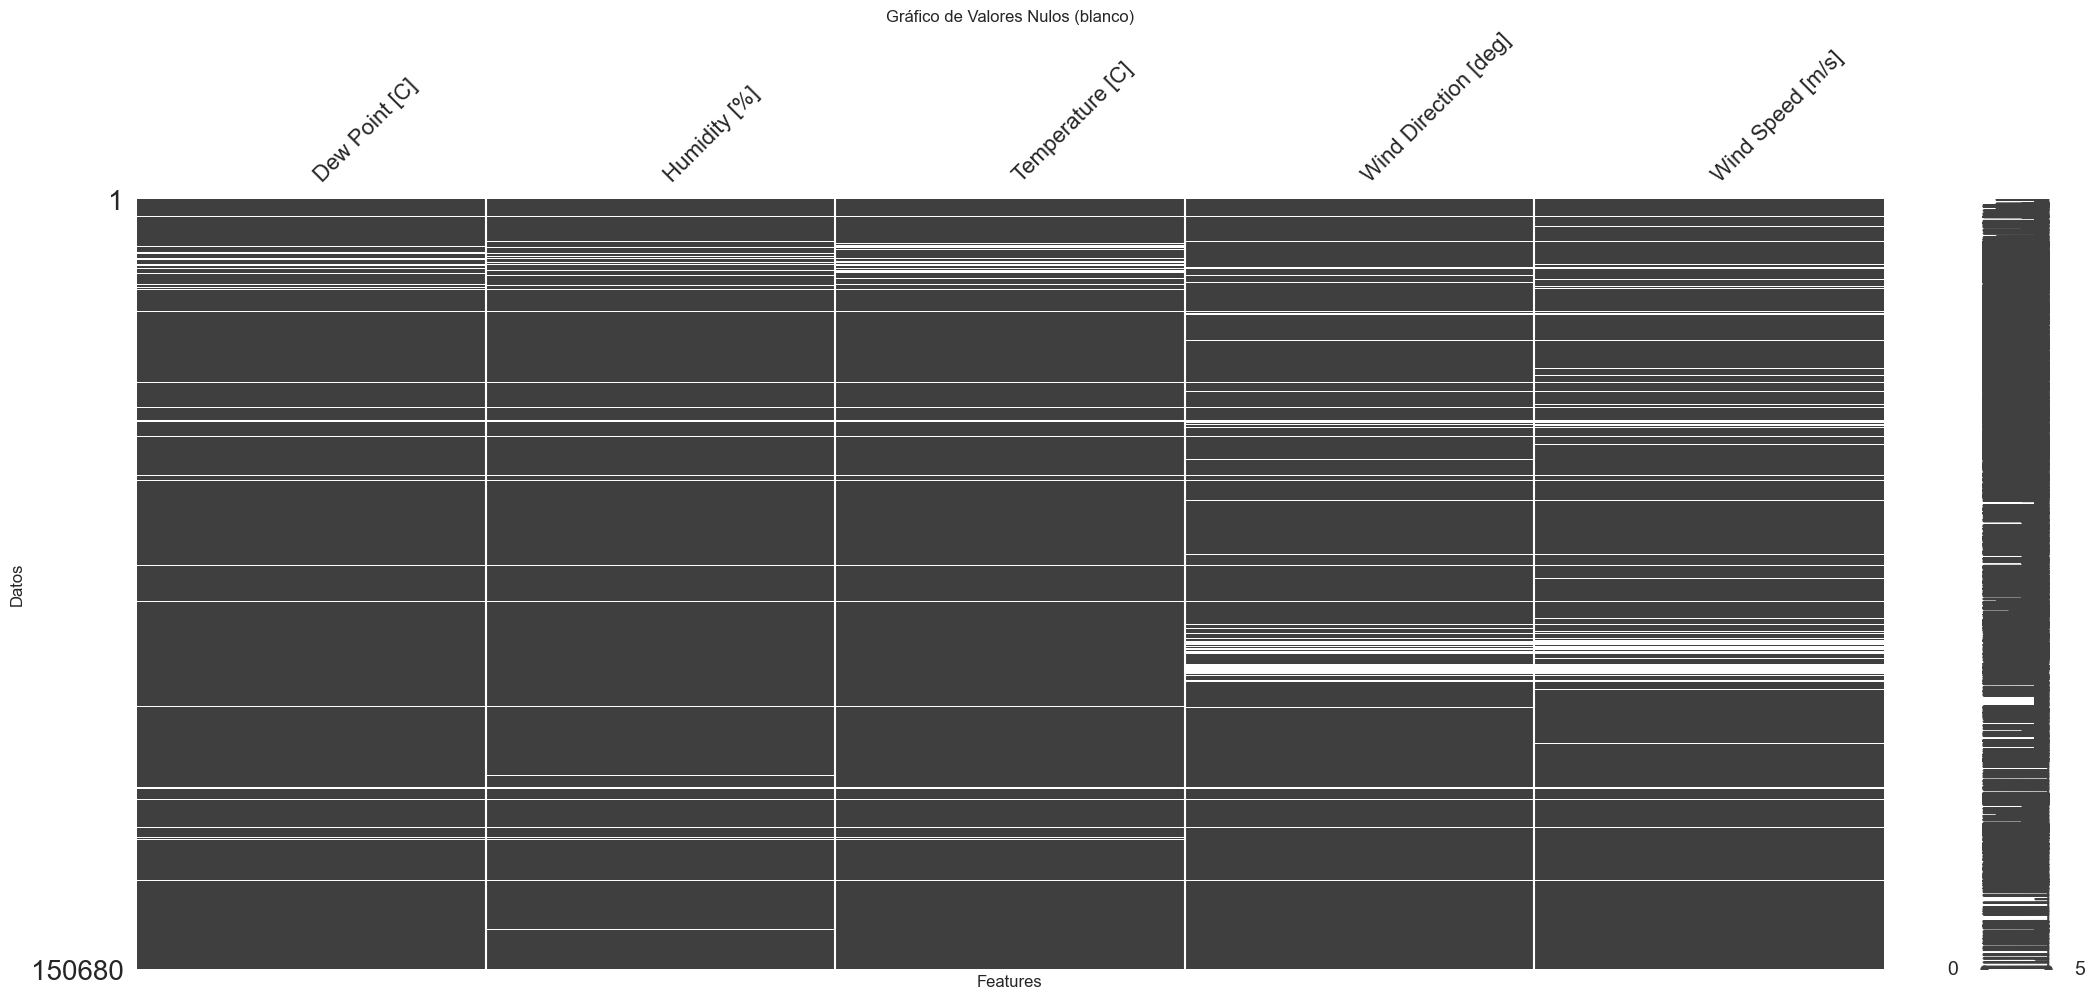

In [12]:
## missing values plot
plt.clf()
msno.matrix(df)
plt.title('Gráfico de Valores Nulos (blanco)')
plt.xlabel('Features')
plt.ylabel('Datos')
plt.show()

In [18]:
date_range = pd.date_range(start='2006-01-01 00:00:00	', end='2024-02-05 22:00:00', freq='H')
df_timestamp = pd.DataFrame(index=date_range)
merged_df = pd.merge(df, df_timestamp, left_index=True, right_index=True, how='right')

/var/folders/b0/69vxpwp54bj58xqzl4ynkwbw0000gn/T/ipykernel_56932/1167688247.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start='2006-01-01 00:00:00	', end='2024-02-05 22:00:00', freq='H')


<Figure size 640x480 with 0 Axes>

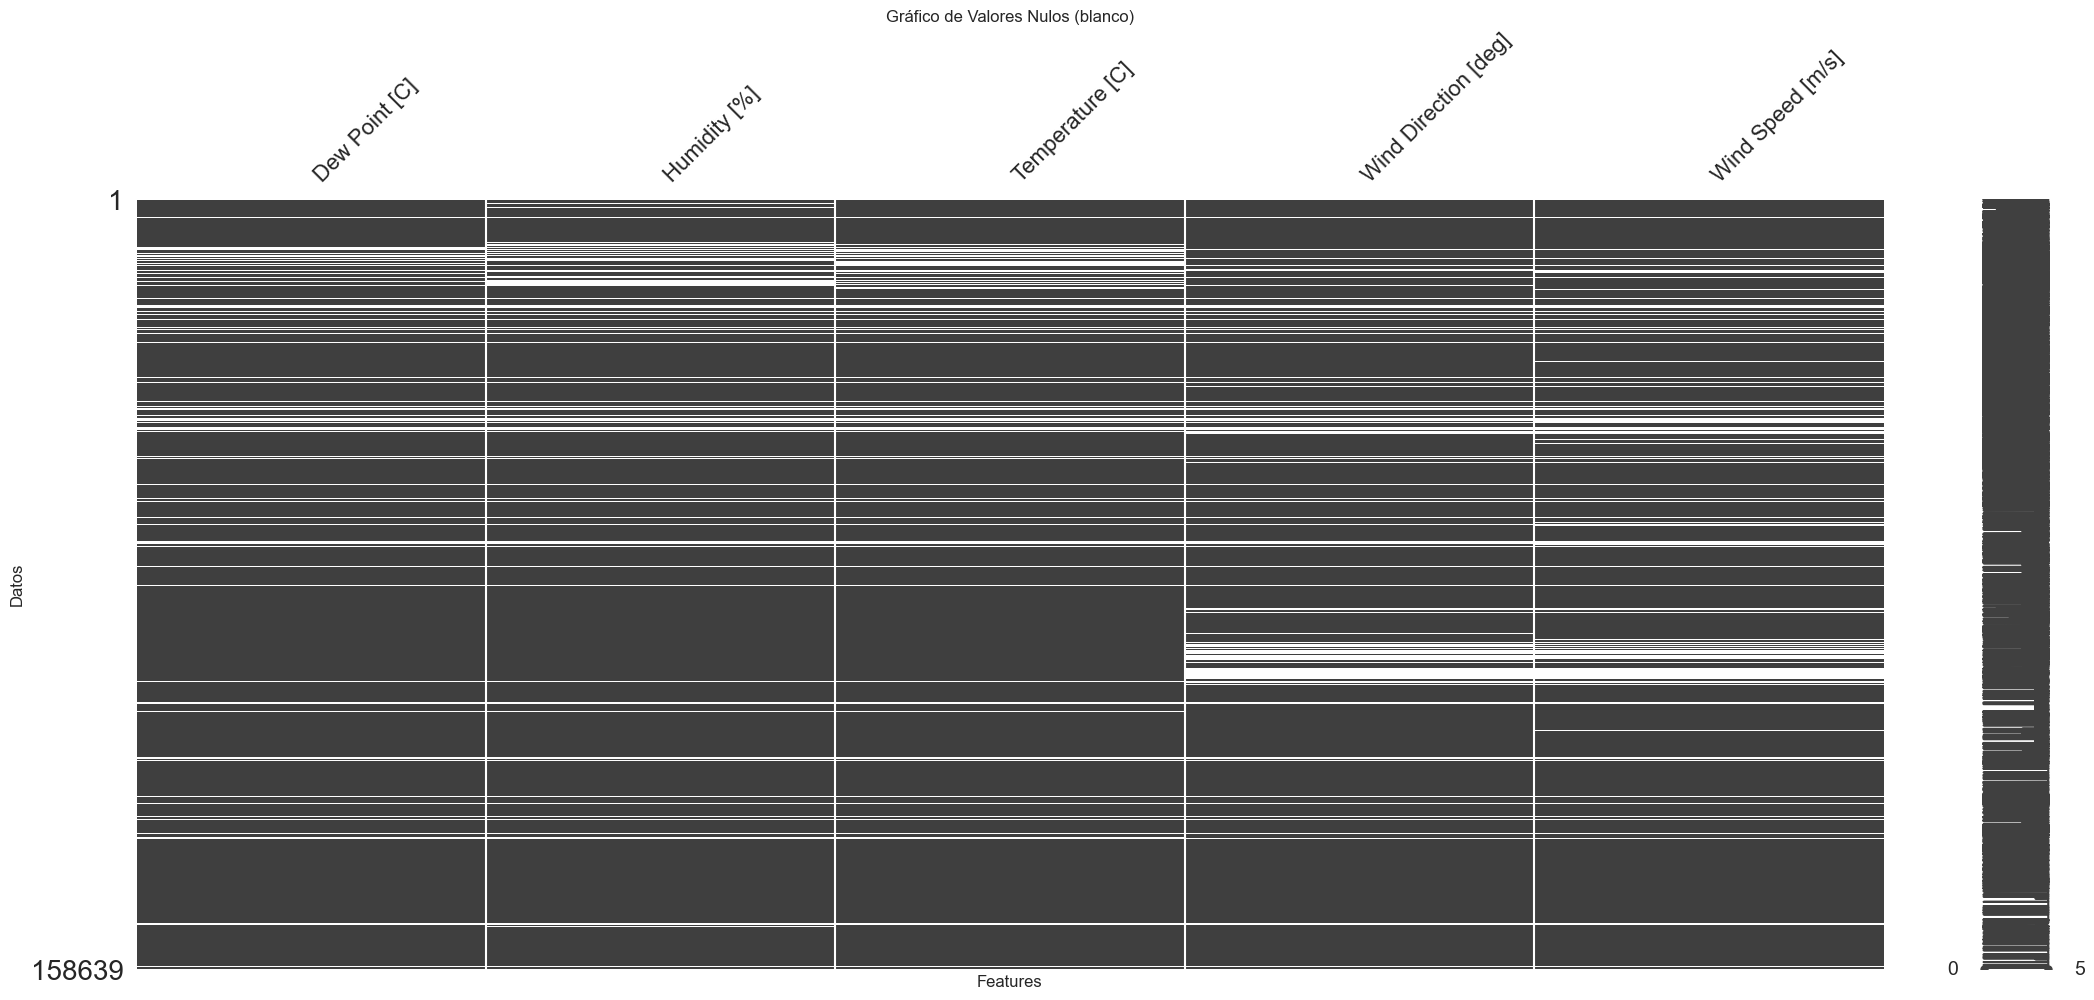

In [20]:
## All missing values
plt.clf()
msno.matrix(merged_df)
plt.title('Gráfico de Valores Nulos (blanco)')
plt.xlabel('Features')
plt.ylabel('Datos')
plt.show()

we see missing values are most related to last two columns: wind direction and wind speed

In [22]:
def get_null_intervals(merged_df,column='Wind Direction at 30m (0/360) [deg]'):
    m = merged_df[column].isna()
    r = [[*g.index] for _, g in merged_df[m].groupby((~m).cumsum())]
    intervals = [(a[0],a[-1]) for a in r]
    return pd.DataFrame([[a[0],a[1],(a[1]-a[0]).seconds/3600] for a in intervals],
                columns=['inicial','final','horas']).sort_values('horas',ascending=False).reset_index(drop=True)

In [25]:
merged_df.isna().sum()

Dew Point [C]           13876
Humidity [%]            15246
Temperature [C]         14363
Wind Direction [deg]    19397
Wind Speed [m/s]        20238
dtype: int64

In [30]:
intervals_df = get_null_intervals(merged_df,column='Wind Speed [m/s]')
print('Total Hours of missing values for Wind Speed:',intervals_df.horas.sum())

Total Hours of missing values for Wind Speed: 8317.0


in the worst case we have a total of 8317 hours with missing values in a column, in this case wind speed.

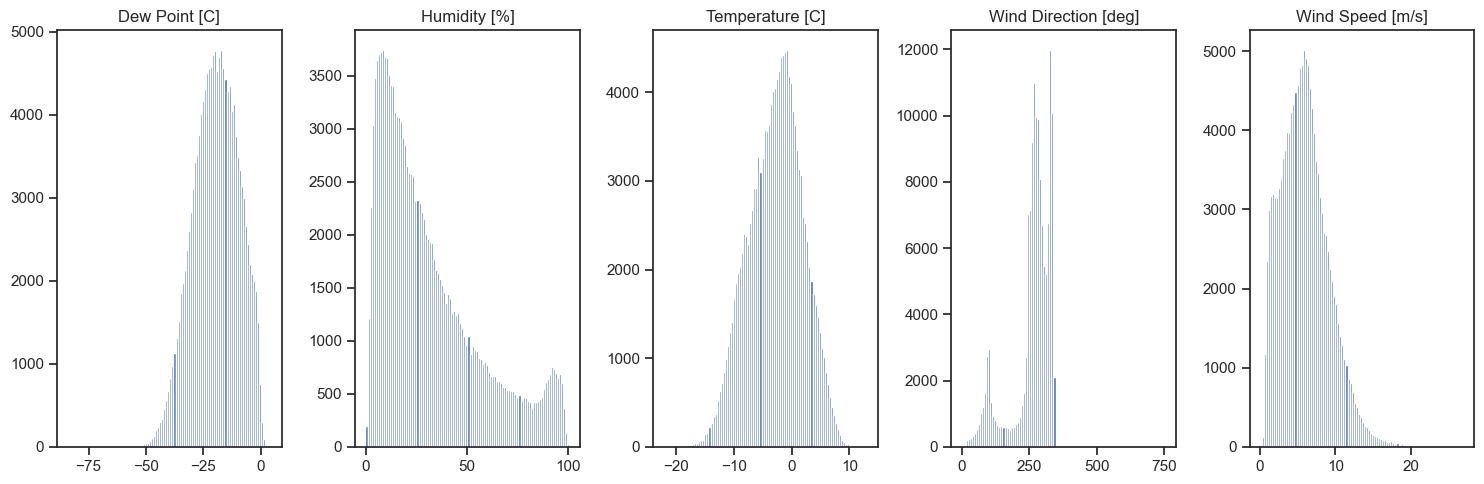

In [15]:
fig, axs = plt.subplots(1, df.shape[1], figsize=(15, 5))

for i,feature in enumerate(list(df.columns)):
    axs[i].hist( df[feature] , bins=100)
    axs[i].set_title(f'{feature}')
plt.tight_layout()
plt.show()

remark: winf direction follow a distribution according to degrees, so it is multimodal. Rest of them only has one moda.